Here I code and discuss the example discussed in https://www.quantopian.com/posts/machine-learning-on-quantopian 

In [1]:
from quantopian.research import run_pipeline
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.factors import CustomFactor, SimpleMovingAverage, AverageDollarVolume, Returns, RSI,Latest
from quantopian.pipeline.classifiers.morningstar import Sector
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline.data.quandl import fred_usdontd156n as libor
from quantopian.pipeline.data.zacks import EarningsSurprises

import talib
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn import linear_model, decomposition, ensemble, preprocessing

# Data creation and cleaning

define a hell of factors

In [2]:
bs = morningstar.balance_sheet
cfs = morningstar.cash_flow_statement
is_ = morningstar.income_statement
or_ = morningstar.operation_ratios
er = morningstar.earnings_report
v = morningstar.valuation
vr = morningstar.valuation_ratios


def make_factors():
    def Asset_Growth_3M():
        return Returns(inputs=[bs.total_assets], window_length=63)

    def Asset_To_Equity_Ratio():
        return bs.total_assets.latest / bs.common_stock_equity.latest

    def Capex_To_Cashflows():
        return (cfs.capital_expenditure.latest * 4.) / \
            (cfs.free_cash_flow.latest * 4.)
        
    def EBITDA_Yield():
        return (is_.ebitda.latest * 4.) / \
            USEquityPricing.close.latest        

    def EBIT_To_Assets():
        return (is_.ebit.latest * 4.) / \
            bs.total_assets.latest
        
    def Earnings_Quality():
        return morningstar.cash_flow_statement.operating_cash_flow.latest / \
               EarningsSurprises.eps_act.latest
        
    def Return_On_Total_Invest_Capital():
        return or_.roic.latest
    
    class Mean_Reversion_1M(CustomFactor):
        inputs = [Returns(window_length=21)]
        window_length = 252

        def compute(self, today, assets, out, monthly_rets):
            out[:] = (monthly_rets[-1] - np.nanmean(monthly_rets, axis=0)) / \
                np.nanstd(monthly_rets, axis=0)
                
    class MACD_Signal_10d(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 60

        def compute(self, today, assets, out, close):

            sig_lines = []

            for col in close.T:
                # get signal line only
                try:
                    _, signal_line, _ = talib.MACD(col, fastperiod=12,
                                                   slowperiod=26, signalperiod=10)
                    sig_lines.append(signal_line[-1])
                # if error calculating, return NaN
                except:
                    sig_lines.append(np.nan)
            out[:] = sig_lines 
            
    class Moneyflow_Volume_5d(CustomFactor):
        inputs = [USEquityPricing.close, USEquityPricing.volume]
        window_length = 5

        def compute(self, today, assets, out, close, volume):

            mfvs = []

            for col_c, col_v in zip(close.T, volume.T):

                # denominator
                denominator = np.dot(col_c, col_v)

                # numerator
                numerator = 0.
                for n, price in enumerate(col_c.tolist()):
                    if price > col_c[n - 1]:
                        numerator += price * col_v[n]
                    else:
                        numerator -= price * col_v[n]

                mfvs.append(numerator / denominator)
            out[:] = mfvs  
            
           
    def Net_Income_Margin():
        return or_.net_margin.latest           

    def Operating_Cashflows_To_Assets():
        return (cfs.operating_cash_flow.latest * 4.) / \
            bs.total_assets.latest

    def Price_Momentum_3M():
        return Returns(window_length=63)
    
    class Price_Oscillator(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 252

        def compute(self, today, assets, out, close):
            four_week_period = close[-20:]
            out[:] = (np.nanmean(four_week_period, axis=0) /
                      np.nanmean(close, axis=0)) - 1.
    
    def Returns_39W():
        return Returns(window_length=215)
    
    class Trendline(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 252

        # using MLE for speed
        def compute(self, today, assets, out, close):

            # prepare X matrix (x_is - x_bar)
            X = range(self.window_length)
            X_bar = np.nanmean(X)
            X_vector = X - X_bar
            X_matrix = np.tile(X_vector, (len(close.T), 1)).T

            # prepare Y matrix (y_is - y_bar)
            Y_bar = np.nanmean(close, axis=0)
            Y_bars = np.tile(Y_bar, (self.window_length, 1))
            Y_matrix = close - Y_bars

            # prepare variance of X
            X_var = np.nanvar(X)

            # multiply X matrix an Y matrix and sum (dot product)
            # then divide by variance of X
            # this gives the MLE of Beta
            out[:] = (np.sum((X_matrix * Y_matrix), axis=0) / X_var) / \
                (self.window_length)
        
    class Vol_3M(CustomFactor):
        inputs = [Returns(window_length=2)]
        window_length = 63

        def compute(self, today, assets, out, rets):
            out[:] = np.nanstd(rets, axis=0)
            
    def Working_Capital_To_Assets():
        return bs.working_capital.latest / bs.total_assets.latest
        
    all_factors = {
        'Asset Growth 3M': Asset_Growth_3M,
        'Asset to Equity Ratio': Asset_To_Equity_Ratio,
        'Capex to Cashflows': Capex_To_Cashflows,
        'EBIT to Assets': EBIT_To_Assets,
        'EBITDA Yield': EBITDA_Yield,        
        'Earnings Quality': Earnings_Quality,
        'MACD Signal Line': MACD_Signal_10d,
        'Mean Reversion 1M': Mean_Reversion_1M,
        'Moneyflow Volume 5D': Moneyflow_Volume_5d,
        'Net Income Margin': Net_Income_Margin,        
        'Operating Cashflows to Assets': Operating_Cashflows_To_Assets,
        'Price Momentum 3M': Price_Momentum_3M,
        'Price Oscillator': Price_Oscillator,
        'Return on Invest Capital': Return_On_Total_Invest_Capital,
        '39 Week Returns': Returns_39W,
        'Trendline': Trendline,
        'Vol 3M': Vol_3M,
        'Working Capital to Assets': Working_Capital_To_Assets,        
    }        
    
    return all_factors

add returns and whether the stock is in top/bottom 30% in returns in pipeline

In [3]:
def make_pipeline(n_fwd_days):
    pipe_screen=QTradableStocksUS()
    factors=make_factors()
    factor_ranks = {name: f().rank(mask=QTradableStocksUS()) for name, f in factors.iteritems()}
    returns=Returns(inputs=[USEquityPricing.open],mask=QTradableStocksUS(), window_length=n_fwd_days)
    pipe_columns=factor_ranks
    pipe_columns['returns']=returns
    pipe_columns['top_returns']=returns.percentile_between(70,100)
    pipe_columns['bottom_returns']=returns.percentile_between(0,30)
    return Pipeline(screen=pipe_screen,columns=pipe_columns)

In [4]:
start_date = "2017-01-01"
end_date = "2017-06-01"
n_fwd_days=5

In [5]:
output=run_pipeline(make_pipeline(n_fwd_days),start_date,end_date)
output.head()

/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:1147: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)
/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


39 Week Returns  Asset Growth 3M  \
2017-01-03 00:00:00+00:00 Equity(2 [ARNC])              65.0             46.0   
                          Equity(24 [AAPL])            995.0             47.0   
                          Equity(31 [ABAX])           1292.0             48.0   
                          Equity(41 [ARCB])           1430.0             49.0   
                          Equity(52 [ABM])            1261.0           1925.0   

                                             Asset to Equity Ratio  \
2017-01-03 00:00:00+00:00 Equity(2 [ARNC])                  1329.0   
                          Equity(24 [AAPL])                 1056.0   
                          Equity(31 [ABAX])                  139.0   
                          Equity(41 [ARCB])                  896.0   
                          Equity(52 [ABM])                   967.0   

                                             Capex to Cashflows  \
2017-01-03 00:00:00+00:00 Equity(2 [ARNC])                 19.0   
                          Equity(24 [AAPL])               670.0   
                          Equity(31 [ABAX])               293.0   
                          Equity(41 [ARCB])               186.0   
                          Equity(52 [ABM])               1854.0   

                                             EBIT to Assets  EBITDA Yield  \
2017-01-03 00:00:00+00:00 Equity(2 [ARNC])            736.0        1935.0   
                          Equity(24 [AAPL])          1560.0        1985.0   
                          Equity(31 [ABAX])          1581.0         302.0   
                          Equity(41 [ARCB])           911.0         929.0   
                          Equity(52 [ABM])            464.0         527.0   

                                             Earnings Quality  \
2017-01-03 00:00:00+00:00 Equity(2 [ARNC])                NaN   
                          Equity(24 [AAPL])            1966.0   
                          Equity(31 [ABAX])             378.0   
                          Equity(41 [ARCB])             751.0   
                          Equity(52 [ABM])              395.0   

                                             MACD Signal Line  \
2017-01-03 00:00:00+00:00 Equity(2 [ARNC])              183.0   
                          Equity(24 [AAPL])            1598.0   
                          Equity(31 [ABAX])             831.0   
                          Equity(41 [ARCB])            1288.0   
                          Equity(52 [ABM])              317.0   

                                             Mean Reversion 1M  \
2017-01-03 00:00:00+00:00 Equity(2 [ARNC])               638.0   
                          Equity(24 [AAPL])             1620.0   
                          Equity(31 [ABAX])             1255.0   
                          Equity(41 [ARCB])              151.0   
                          Equity(52 [ABM])                26.0   

                                             Moneyflow Volume 5D     ...       \
2017-01-03 00:00:00+00:00 Equity(2 [ARNC])                  10.0     ...        
                          Equity(24 [AAPL])                406.0     ...        
                          Equity(31 [ABAX])                602.0     ...        
                          Equity(41 [ARCB])                593.0     ...        
                          Equity(52 [ABM])                1674.0     ...        

                                             Operating Cashflows to Assets  \
2017-01-03 00:00:00+00:00 Equity(2 [ARNC])                           509.0   
                          Equity(24 [AAPL])                         1764.0   
                          Equity(31 [ABAX])                         1004.0   
                          Equity(41 [ARCB])                         1237.0   
                          Equity(52 [ABM])                           405.0   

                                             Price Momentum 3M  \
2017-01-03 00:00:00+00:00 Equity(2 [ARNC])                18.0   
    

In [6]:
feature=output.copy()
feature.drop(['returns','top_returns','bottom_returns'],axis=1,inplace=True)
feature

39 Week Returns  \
2017-01-03 00:00:00+00:00 Equity(2 [ARNC])                   65.0   
                          Equity(24 [AAPL])                 995.0   
                          Equity(31 [ABAX])                1292.0   
                          Equity(41 [ARCB])                1430.0   
                          Equity(52 [ABM])                 1261.0   
                          Equity(53 [ABMD])                1424.0   
                          Equity(62 [ABT])                  330.0   
                          Equity(64 [ABX])                  911.0   
                          Equity(67 [ADSK])                1516.0   
                          Equity(76 [TAP])                  829.0   
                          Equity(84 [ACET])                 382.0   
                          Equity(110 [ACXM])               1177.0   
                          Equity(114 [ADBE])                915.0   
                          Equity(122 [ADI])                1404.0   
                          Equity(128 [ADM])                1307.0   
                          Equity(154 [AEM])                1013.0   
                          Equity(161 [AEP])                 457.0   
                          Equity(166 [AES])                 981.0   
                          Equity(168 [AET])                 743.0   
                          Equity(185 [AFL])                 886.0   
                          Equity(197 [AGCO])               1002.0   
                          Equity(216 [HES])                1561.0   
                          Equity(239 [AIG])                1217.0   
                          Equity(247 [AIN])                1183.0   
                          Equity(253 [AIR])                1661.0   
                          Equity(266 [AJG])                1302.0   
                          Equity(270 [AKRX])                110.0   
                          Equity(289 [MATX])                213.0   
                          Equity(300 [ALK])                 963.0   
                          Equity(301 [ALKS])               1782.0   
...                                                           ...   
2017-06-01 00:00:00+00:00 Equity(49610 [SQ])               2070.0   
                          Equity(49615 [DLTH])              216.0   
                          Equity(49630 [CSRA])             1273.0   
                          Equity(49655 [TEAM])             1492.0   
                          Equity(49666 [AGR])               785.0   
                          Equity(49700 [FCE_A])             538.0   
                          Equity(49727 [GCP])              1001.0   
                          Equity(49736 [EDIT])               38.0   
                          Equity(49751 [AVXS])             2018.0   
                          Equity(49760 [WBT])               969.0   
                          Equity(49877 [PNK])              2014.0   
                          Equity(49883 [LSXM_K])           1459.0   
                          Equity(49891 [MGP])              1014.0   
                          Equity(49908 [RRR])               978.0   
                          Equity(49925 [NGVT])             1833.0   
                          Equity(49959 [SITE])             1659.0   
                          Equity(50002 [COTV])             1911.0   
                          Equity(50003 [USFD])             1353.0   
                          Equity(50004 [GMS])              1543.0   
                          Equity(50040 [ATKR])             1505.0   
                          Equity(50049 [FTV])              1540.0   
                          Equity(50070 [HTZ])                 2.0   
                          Equity(50077 [TWLO])               73.0   
                          Equity(50119 [TRTN])             2008.0   
                          Equity(50132 [APFH])             1989.0   
                          Equity(50138 [PI])               2062.0   
                          Equity(50143 [PTHN])  

The target will be whether the stocks's return in future (5 days horizon) is among top 30 percent or bottom 30 percent

In [7]:
target=output['top_returns']*1.0-output['bottom_returns']*1.0
target

2017-01-03 00:00:00+00:00  Equity(2 [ARNC])         -1.0
                           Equity(24 [AAPL])         1.0
                           Equity(31 [ABAX])         1.0
                           Equity(41 [ARCB])         0.0
                           Equity(52 [ABM])          1.0
                           Equity(53 [ABMD])         1.0
                           Equity(62 [ABT])          0.0
                           Equity(64 [ABX])          1.0
                           Equity(67 [ADSK])         1.0
                           Equity(76 [TAP])          1.0
                           Equity(84 [ACET])         1.0
                           Equity(110 [ACXM])        1.0
                           Equity(114 [ADBE])        0.0
                           Equity(122 [ADI])         0.0
                           Equity(128 [ADM])         0.0
                           Equity(154 [AEM])         1.0
                           Equity(161 [AEP])         0.0
                           Equi

In [8]:
asset_list=feature.index.levels[1]
len(asset_list)

2191

In [110]:
X=[]
for asset in asset_list:
    tempx=np.array(feature.xs(asset,level=1))
    tempy=np.array(target.xs(asset,level=1))
    tempy=tempy.reshape((len(tempy),1))
    # shift the return value by n_fwd_days and select only those that are in top or bottom group
    tempX=np.concatenate((tempx[:-n_fwd_days],tempy[n_fwd_days:]),axis=1)
    tempX=tempX[tempX[:,-1]!=0]
    if len(X)==0:
        X=tempX
    else:
        X=np.concatenate((X,tempX))

In [111]:
X.shape

(122823, 19)

final data preprocessing

In [112]:
X_p=preprocessing.Imputer().fit_transform(X) #fill nan
X_p=preprocessing.MinMaxScaler().fit_transform(X_p) # normalize data

# Trainning/testing model

shuffle the data and separate into training and test group

In [113]:
X_p=np.random.permutation(X_p)

In [114]:
X_train=X_p[:int(len(X)*0.7)]
X_test=X_p[int(len(X)*0.7):]

In [115]:
clf = ensemble.GradientBoostingClassifier(n_estimators=150)

In [116]:
clf.fit(X_train[:,:18],X_train[:,18])

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=150,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

in sample prediction accuracy

In [117]:
clf.score(X_train[:,:18],X_train[:,18])

0.59237461617195497

out sample prediction accuracy

In [118]:
clf.score(X_test[:,:18],X_test[:,18])

0.57266534588976037

If we make random guess, by central limit theorem we will have an acuracy 0.5 with standard deviation $\sqrt{0.5*0.5/36847}=0.0026$. So this null hypothesis can be rejected, and there is "something" in this prediction

Now we look at the feature importance

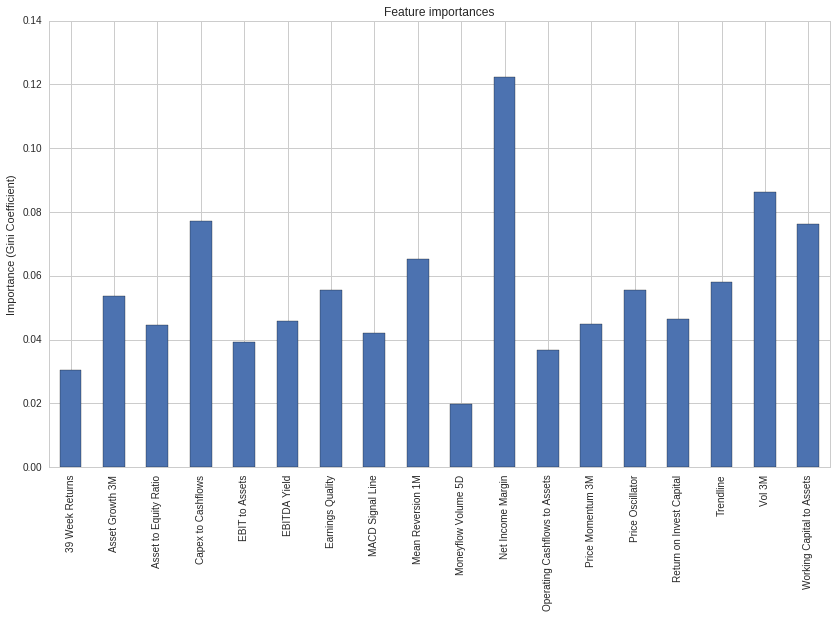

In [119]:
feature_importances = pd.Series(clf.feature_importances_, index=feature.columns)
ax = feature_importances.plot(kind='bar')
ax.set(ylabel='Importance (Gini Coefficient)', title='Feature importances');

Considering these data are actually time series, it might make more sense to allocate the trainning and test data according to time

In [63]:
X=[]
for asset in asset_list:
    tempx=np.array(feature.xs(asset,level=1))
    tempy=np.array(target.xs(asset,level=1))
    tempy=tempy.reshape((len(tempy),1))
    #create an additional column indicating the time of the data
    timelabel=range(len(tempx)-n_fwd_days)
    timelabel=np.array(timelabel).reshape((len(timelabel),1))
    # shift the return value by n_fwd_days and select only those that are in top or bottom group
    tempX=np.concatenate((tempx[:-n_fwd_days],tempy[n_fwd_days:],timelabel),axis=1)
    tempX=tempX[tempX[:,-2]!=0]
    if len(X)==0:
        X=tempX
    else:
        X=np.concatenate((X,tempX))

In [37]:
X.shape

(122823, 20)

In [64]:
X_p=preprocessing.Imputer().fit_transform(X)
X_p=preprocessing.MinMaxScaler().fit_transform(X_p)

We determine the train and test data according to the value int time columns, note that this column was already normalized to value 0 to 1 by previous function

In [65]:
X_train=X_p[X_p[:,-1]<=0.6]
X_test=X_p[X_p[:,-1]>0.6]

In [66]:
len(X_train)

75153

In [106]:
clf = ensemble.GradientBoostingClassifier(n_estimators=150)

In [107]:
clf.fit(X_train[:,:18],X_train[:,18])

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=150,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [108]:
clf.score(X_train[:,:18],X_train[:,18])

0.6065093875161337

The out sample prediction is less impressive but still significant

In [109]:
clf.score(X_test[:,:18],X_test[:,18])

0.52662051604782878

The feature importances changes a bit comparing to the previous model

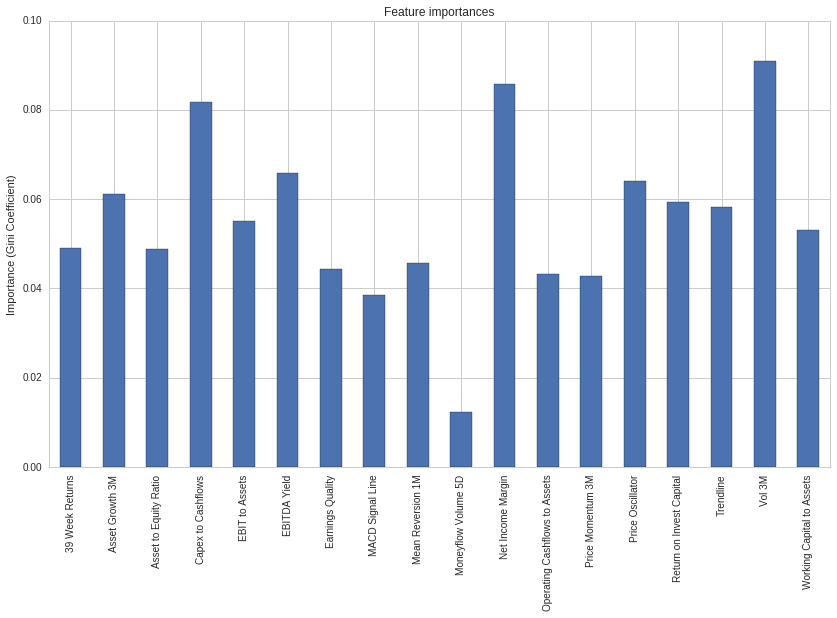

In [52]:
feature_importances = pd.Series(clf.feature_importances_, index=feature.columns)
ax = feature_importances.plot(kind='bar')
ax.set(ylabel='Importance (Gini Coefficient)', title='Feature importances');

In [94]:
clf = ensemble.RandomForestClassifier(n_estimators=200,max_leaf_nodes=20)

In [95]:
clf.fit(X_train[:,:18],X_train[:,18])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=20,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [96]:
clf.score(X_train[:,:18],X_train[:,18])

0.57083549558899849

In [97]:
clf.score(X_test[:,:18],X_test[:,18])

0.52542479546884835